## 1. 載入套件
### 2. SMA 3.8.19


In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# 設定中文字體
plt.rcParams['axes.unicode_minus']=False

## 2. 資料前處理

我們組使用東森新聞網 財經、健康、政治、體育 這四個主題的新聞來做主題分析

In [4]:
data = pd.read_csv("data\聯合新聞爬蟲.csv")  # 匯資料
data.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,美國溫蒂漢堡 不只AI點餐還開發地底送餐隧道,2023-05-24 17:13:00,產經,NaN,https://udn.com/news/story/121591/7187912,透過AI點餐已經不稀奇了，美國溫蒂漢堡宣布將透過AI對話聊天機器人，服務得來速的客戶，現在他...,UDN
1,2,特斯拉自建資料中心 資安是新的關注焦點,2023-08-16 15:47:00,產經,NaN,https://udn.com/news/story/121591/7373565,電動車大廠特斯拉原在上海架設自己的資料中心，維護廣大中國用戶的自駕運用資料庫，然而受到中國資...,UDN
2,3,卡位日本製造業起飛 元大日本龍頭企業基金展開第二次追加募集,2023-09-05 11:33:00,產經,NaN,https://udn.com/news/story/121591/7417321,日圓維持相對弱勢，帶動日本製造業上修獲利預期，國內首檔聚焦日本製造業的「元大日本龍頭企業基金...,UDN


In [5]:
# 移除網址格式
# 只留下中文字
data["artContent"] = data["artContent"].str.replace("(http|https)://.*", "", regex=True)
data["artTitle"] = data["artTitle"].str.replace("(http|https)://.*", "", regex=True)
data["artContent"] = data["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
data["artTitle"] = data["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
data['content'] = data['artContent']


data = data.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
data.head(3)

,content,artUrl,artCatagory,artDate
0,透過點餐已經不稀奇了美國溫蒂漢堡宣布將透過對話聊天機器人服務得來速的客戶現在他們又打算跟物流...,https://udn.com/news/story/121591/7187912,產經,2023-05-24 17:13:00
1,電動車大廠特斯拉原在上海架設自己的資料中心維護廣大中國用戶的自駕運用資料庫然而受到中國資訊安...,https://udn.com/news/story/121591/7373565,產經,2023-08-16 15:47:00
2,日圓維持相對弱勢帶動日本製造業上修獲利預期國內首檔聚焦日本製造業的元大日本龍頭企業基金掀起國...,https://udn.com/news/story/121591/7417321,產經,2023-09-05 11:33:00


In [6]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

data["words"] = data["content"].apply(getToken)
data.head()

Building prefix dict from d:\114 NSYSU MIS\SMA 特斯拉\dict\dict.txt.big ...
2024-05-28 15:13:55,925 : DEBUG : Building prefix dict from d:\114 NSYSU MIS\SMA 特斯拉\dict\dict.txt.big ...
Loading model from cache C:\Users\hands\AppData\Local\Temp\jieba.u1752730e949ce936bc5656ff748cc02c.cache
2024-05-28 15:13:55,933 : DEBUG : Loading model from cache C:\Users\hands\AppData\Local\Temp\jieba.u1752730e949ce936bc5656ff748cc02c.cache
Loading model cost 1.721 seconds.
2024-05-28 15:13:57,652 : DEBUG : Loading model cost 1.721 seconds.
Prefix dict has been built successfully.
2024-05-28 15:13:57,655 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,透過點餐已經不稀奇了美國溫蒂漢堡宣布將透過對話聊天機器人服務得來速的客戶現在他們又打算跟物流...,https://udn.com/news/story/121591/7187912,產經,2023-05-24 17:13:00,"[透過, 點餐, 已經, 稀奇, 美國, 溫蒂, 漢堡, 宣布, 透過, 對話, 聊天, 機..."
1,電動車大廠特斯拉原在上海架設自己的資料中心維護廣大中國用戶的自駕運用資料庫然而受到中國資訊安...,https://udn.com/news/story/121591/7373565,產經,2023-08-16 15:47:00,"[電動車, 大廠, 特斯拉, 原在, 上海, 架設, 資料, 中心, 維護, 廣大, 中國,..."
2,日圓維持相對弱勢帶動日本製造業上修獲利預期國內首檔聚焦日本製造業的元大日本龍頭企業基金掀起國...,https://udn.com/news/story/121591/7417321,產經,2023-09-05 11:33:00,"[日圓, 維持, 相對, 弱勢, 帶動, 日本, 製造業, 上修, 獲利, 預期, 國內, ..."
3,在年德國慕尼黑車展上發現不少亮點印證先前外資券商預估年電動車應用將帶領人工智慧落地化應用更進...,https://udn.com/news/story/121591/7532017,產經,2023-10-26 17:26:00,"[德國, 慕尼黑, 車展, 發現, 亮點, 印證, 先前, 外資, 券商, 預估, 電動車,..."
4,台灣碳權交易所今天成立節能減碳進入一個新里程碑學者指出台灣已有碳權可做為交易標的重點是氣候變...,https://udn.com/news/story/123674/7352264,產經,2023-08-07 14:18:00,"[台灣, 碳權, 交易所, 今天, 成立, 節能, 減碳, 進入, 里程碑, 學者, 指出,..."


## 3. Lexicon-based / 人工給定主題的主題模型

In [7]:
data['artCatagory'].unique()

array(['產經', '股市'], dtype=object)

In [8]:
# 定義主題(財經)
finance_cnt = data.loc[data['artCatagory'] == '財經',:]['words'].explode().value_counts().head(100)
finance_cnt.index

Index([], dtype='object')

In [9]:
# 定義主題(健康)
health_cnt = data.loc[data['artCatagory'] == '健康',:]['words'].explode().value_counts().head(200)
pprint(" ".join(health_cnt.index))

''


In [10]:
# 定義主題(政治)
politics_cnt = data.loc[data['artCatagory'] == '政治',:]['words'].explode().value_counts().head(200)
pprint(" ".join(politics_cnt.index))

''


In [11]:
# 定義主題(體育)
exercise_cnt = data.loc[data['artCatagory'] == '體育',:]['words'].explode().value_counts().head(200)
pprint(" ".join(exercise_cnt.index))

''


從上面各個主題挑出比較重要的字詞

In [12]:
custom_topic_word = {
    "財金": [
        "投資",
        "億元",
        "市場",
        "萬元",
        "股價",
        "指數",
        "美元",
        "日圓",
        "台幣",
        "股票",
        "金額",
        "升息",
        "利率",
        "基金",
        "投資人",
        "全球",
        "漲幅",
        "成本",
        "產業"
    ],
    "健康": [
        "醫師",
        "症狀",
        "發現",
        "糖尿病",
        "治療",
        "患者",
        "健康",
        "感染",
        "建議",
        "慢性",
        "檢查",
        "疾病",
        "身體",
        "醫院",
        "疫苗",
        "研究",
        "風險",
        "影響",
        "嚴重",
        "食物",
        "呼吸道",
        "就醫",
        "避免",
        "藥物",
        "病毒",
        "感冒",
        "診斷",
        "時間",
        "急診",
        "癌症",
        "異常",
        "心血管",
        "手術",
        "發炎",
        "飲食",
        "腫瘤",
        "睡眠",
        "罹患",
        "代謝"
    ],
    "政治": [
        "總統",
        "國民黨",
        "立委",
        "民進黨",
        "柯文哲",
        "侯友宜",
        "台灣",
        "民眾黨",
        "參選人",
        "市長",
        "賴清德",
        "候選人",
        "支持",
        "主席",
        "選舉",
        "民調",
        "郭台銘",
        "議員",
        "萬安",
        "政治",
        "大選",
        "台北",
        "政府",
        "趙少康",
        "藍營",
        "政黨",
        "院長",
        "國家",
        "當選",
        "台北市",
        "新北",
        "選情",
        "中華民國",
        "藍白合",
        "參選",
        "立法院"
    ],
    "體育":[
        '亞運',
        '選手',
        '台灣',
        '中華隊',
        '比賽',
        '金牌',
        '決賽',
        '成績',
        '對手',
        '美國',
        '銅牌',
        '男子',
        '女子',
        '晉級',
        '世界',
        '冠軍',
        '獲得',
        '成功',
        '運動',
        '韓國',
        '奧運',
        '國際',
        '訓練',
        '獎牌',
        '體育',
        '棒球',
        '羽球',
        '跆拳道',
        '柔道',
        '籃球',
        '杭州',
        '巨蛋',
        '職棒',
        '體操',
        '網友',
        '聯盟',
        '球迷',
        '球隊',
        '教練',
        '球員'
    ]
}

In [13]:
# 把全部定義過的主題詞彙匯整在一起
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [14]:
vocabularies

array(['世界', '中華民國', '中華隊', '主席', '亞運', '代謝', '侯友宜', '候選人', '健康', '億元',
       '全球', '冠軍', '利率', '升息', '參選', '參選人', '台北', '台北市', '台幣', '台灣',
       '呼吸道', '嚴重', '國家', '國民黨', '國際', '基金', '大選', '奧運', '女子', '對手', '就醫',
       '巨蛋', '市場', '市長', '建議', '影響', '心血管', '急診', '患者', '感冒', '感染', '慢性',
       '成功', '成本', '成績', '手術', '投資', '投資人', '指數', '支持', '政府', '政治', '政黨',
       '教練', '新北', '日圓', '時間', '晉級', '杭州', '柔道', '柯文哲', '棒球', '檢查', '比賽',
       '民眾黨', '民調', '民進黨', '決賽', '治療', '漲幅', '獎牌', '獲得', '球員', '球迷', '球隊',
       '產業', '男子', '異常', '當選', '疫苗', '疾病', '病毒', '症狀', '癌症', '發炎', '發現',
       '睡眠', '研究', '立委', '立法院', '籃球', '糖尿病', '網友', '總統', '罹患', '美元', '美國',
       '羽球', '聯盟', '職棒', '股價', '股票', '腫瘤', '萬元', '萬安', '藍營', '藍白合', '藥物',
       '訓練', '診斷', '議員', '賴清德', '趙少康', '跆拳道', '身體', '運動', '選情', '選手',
       '選舉', '避免', '郭台銘', '醫師', '醫院', '金牌', '金額', '銅牌', '院長', '韓國', '風險',
       '食物', '飲食', '體操', '體育'], dtype='<U4')

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [15]:
data_corpus = data['words'].map(" ".join)
data_corpus

0       透過 點餐 已經 稀奇 美國 溫蒂 漢堡 宣布 透過 對話 聊天 機器人 服務 得來 客戶 ...
1       電動車 大廠 特斯拉 原在 上海 架設 資料 中心 維護 廣大 中國 用戶 自駕 運用 資料...
2       日圓 維持 相對 弱勢 帶動 日本 製造業 上修 獲利 預期 國內 首檔 聚焦 日本 製造業...
3       德國 慕尼黑 車展 發現 亮點 印證 先前 外資 券商 預估 電動車 應用 帶領 人工智慧 ...
4       台灣 碳權 交易所 今天 成立 節能 減碳 進入 里程碑 學者 指出 台灣 已有 碳權 交易...
                              ...                        
1179    美系 券商 最新 報告 指出 電動車 電池 價格 大幅 下降 電動車 售價 亦將 降價 激勵...
1180    半導體 類股 上周 大幅 震盪 艾司 摩爾 公布 財報 表示 第季 獲利 先進 晶片 製造 ...
1181    乙盛 受惠 伺服器 業務 需求 回溫 首季 營收 億元 三季 高點 季增 去年同期 衰退 乙...
1182    美國 科技股 續漲 激勵 台股 開盤 指數 為點 上漲 點台 積電 開盤價 為元 上漲 群益...
1183    節能 減碳 全球 趨勢 電動車 產業 已成 汽車 發展 潮流 法人 樂觀 看待 鴻海 胡連 ...
Name: words, Length: 1184, dtype: object

In [16]:
vectorizer = CountVectorizer(vocabulary=vocabularies)
data_matrix = vectorizer.fit_transform(data_corpus)

data_matrix = data_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

In [17]:
# 文章數 X vocabularies字數
data_matrix.shape

(1184, 133)

In [18]:
df_count = pd.DataFrame({})

for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = data_matrix[:, idx].sum(axis=1)
    
df_count

,topic_財金,topic_健康,topic_政治,topic_體育
0,36,8,2,3
1,40,7,2,5
2,29,0,0,0
3,47,8,7,9
4,11,7,27,30
...,...,...,...,...
1179,12,2,1,3
1180,12,6,3,0
1181,3,2,0,0
1182,26,1,4,5


In [19]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_財金,topic_健康,topic_政治,topic_體育
0,0.734694,0.163265,0.040816,0.061224
1,0.740741,0.129630,0.037037,0.092593
2,1.000000,0.000000,0.000000,0.000000
3,0.661972,0.112676,0.098592,0.126761
4,0.146667,0.093333,0.360000,0.400000


## 4. LDA 主題模型

**4.1 正式處理新聞**

In [20]:
docs = data['words'].to_list()
docs[0]

['透過',
 '點餐',
 '已經',
 '稀奇',
 '美國',
 '溫蒂',
 '漢堡',
 '宣布',
 '透過',
 '對話',
 '聊天',
 '機器人',
 '服務',
 '得來',
 '客戶',
 '現在',
 '打算',
 '物流',
 '公司',
 '合作開發',
 '一款',
 '超有',
 '噱頭',
 '機器人',
 '送餐',
 '隧道',
 '系統',
 '客戶',
 '不用',
 '得來',
 '去取',
 '餐能',
 '簡便',
 '容易',
 '過去',
 '經驗',
 '客戶',
 '從線',
 '上點',
 '選擇',
 '自取',
 '開車',
 '餐廳',
 '外面',
 '停車',
 '走進',
 '去取',
 '得來',
 '車道',
 '排隊',
 '取餐',
 '溫蒂',
 '漢堡',
 '物流業',
 '合作開發',
 '一套',
 '地底',
 '送餐',
 '通道',
 '解決',
 '問題',
 '餐廳',
 '每個',
 '停車位',
 '旁邊',
 '將會',
 '一座',
 '快速',
 '取餐',
 '傳送門',
 '客戶',
 '停車',
 '確認',
 '取單',
 '編號',
 '機器人',
 '廚房',
 '出餐',
 '抓取',
 '正確',
 '餐點',
 '鑽進',
 '複雜',
 '地下隧道',
 '對應',
 '傳送門',
 '位置',
 '餐點',
 '交給',
 '客戶',
 '了解',
 '隧道',
 '全程',
 '溫度',
 '管控',
 '避免',
 '餐點',
 '冷卻',
 '過熱',
 '確保',
 '餐點',
 '品質',
 '客戶',
 '需要',
 '下車',
 '得來',
 '排隊',
 '溫蒂',
 '漢堡',
 '預期',
 '大幅',
 '加快',
 '取餐',
 '速度',
 '客戶',
 '體驗',
 '快速',
 '取餐',
 '應該',
 '願意',
 '再來',
 '消費',
 '這套',
 '系統',
 '還在',
 '測試階段',
 '溫蒂',
 '漢堡',
 '預計',
 '今年',
 '挑選',
 '合適',
 '分店',
 '實裝',
 '這套',
 '系統',
 '觀察',
 '成效',
 '這套',
 '方案',
 '想起'

In [21]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-05-28 15:32:17,526 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-05-28 15:32:18,102 : INFO : built Dictionary<30790 unique tokens: ['一套', '一座', '一款', '三十日', '三大']...> from 1184 documents (total 376066 corpus positions)
2024-05-28 15:32:18,103 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<30790 unique tokens: ['一套', '一座', '一款', '三十日', '三大']...> from 1184 documents (total 376066 corpus positions)", 'datetime': '2024-05-28T15:32:18.103533', 'gensim': '4.3.2', 'python': '3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2024-05-28 15:32:18,144 : INFO : discarding 23788 tokens: [('三十日', 3), ('下車', 2), ('不實', 3), ('中本', 3), ('之融', 3), ('交給', 4), ('亦須', 3), ('以多幣別', 3), ('以非', 3), ('保障機制', 3)]...
2024-05-28 15:32:18,149 : INFO : keeping 7002 tokens which were in no less than 5 and no more than 1172 (=99.0%) documents
2024-05-28 15:32:18,168 : INFO : resulting dictionary:

Dictionary<7002 unique tokens: ['一套', '一座', '一款', '三大', '上點']...>


In [22]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一套: 0
一座: 1
一款: 2
三大: 3
上點: 4
不用: 5
中心: 6
中華民國: 7
中長期: 8
主管機關: 9
之前: 10
了解: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[600]:[(2, 2), (6, 1), (20, 2), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'世界'出現2次、'之戰'出現一次...以此類推

In [23]:
pprint(" ".join(data['words'].iloc[600]))


('特斯拉 墨西哥 蒙特雷 打造 超級 工廠 預計 最快 投產 市場 該廠 產能 規劃 萬輛 有望 旗下 生產 主力 代工 大廠 廣達 打入 特斯拉 供應鏈 '
 '手握 車載 電腦 先進 駕駛 輔助 系統 電子 控制器 元件 大單 資深 副總經理 雲達 總經理 楊麒令 透露 墨國 也將 啟動 擴產 計畫 廣達 旺年 '
 '南港 展覽館 盛大 登場 楊麒令 現身 會場 同慶 面對 媒體 詢問 墨西哥 廠區 產能 狀況 指出 集團 海外 個廠 擴廠 計畫 事實上 包含 北美 '
 '墨西哥 泰國 歐洲 德國 共計 地區 最近 年間 一直 擴廠 擴產 計畫 墨西哥 產品線 規劃 專注 在車 電針 產能 方面 楊麒令 指出 目前 已知 '
 '海外 個廠 擴充 包含 北美 墨西哥 泰國 歐洲 德國 近年 一直 擴廠 擴產 計畫 擴充 停止 產能 海外 平均 內部 今年 考慮 泰國 新建 置產 '
 '綜觀 海外 產能 開出 特斯拉 訂單 貢獻 營收 廣達 車用 業務 最大 至少 達到 七至 公司 因應 車用 電子 訂單 持續 增溫 決定 墨西哥 斥資 '
 '億美元 資金 啟動 擴產 預計 產能 開出 有望 就近 拿下 特斯拉 大單 雲達 總座 楊麒令 記者 吳康瑋 攝影 廣達 旺年 記者 吳康瑋 攝影')


In [24]:
dictionary.doc2bow(data['words'].iloc[600])[:10]

[(14, 1),
 (16, 1),
 (32, 1),
 (64, 1),
 (136, 1),
 (160, 4),
 (184, 1),
 (230, 1),
 (257, 2),
 (292, 1)]

In [25]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [26]:
type(corpus)

list

訓練 topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

In [27]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=8, # 生成幾個主題數
    random_state=6666, # 亂數
)

2024-05-28 15:32:35,853 : INFO : using symmetric alpha at 0.125
2024-05-28 15:32:35,855 : INFO : using symmetric eta at 0.125
2024-05-28 15:32:35,858 : INFO : using serial LDA version on this node
2024-05-28 15:32:35,870 : INFO : running online (single-pass) LDA training, 8 topics, 1 passes over the supplied corpus of 1184 documents, updating model once every 1184 documents, evaluating perplexity every 1184 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-28 15:32:35,871 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-28 15:32:38,076 : INFO : -9.585 per-word bound, 768.2 perplexity estimate based on a held-out corpus of 1184 documents with 331631 words
2024-05-28 15:32:38,077 : INFO : PROGRESS: pass 0, at document #1184/1184
2024-05-28 15:32:39,285 : INFO : topic #2 (0.125): 0.009*"台灣" + 0.008*"電動車" + 0.007*"今年" + 0.006*"特斯拉" + 0.006*"市場" + 0.005*"企業" + 0.005*"億元" + 0.0

**4.2 查看 LDA 主題代表字** <br>  

In [28]:
ldamodel.print_topics()

2024-05-28 15:32:43,897 : INFO : topic #0 (0.125): 0.008*"指數" + 0.006*"市場" + 0.005*"科技" + 0.005*"成長" + 0.005*"表示" + 0.005*"特斯拉" + 0.005*"今年" + 0.004*"投資" + 0.004*"美國" + 0.004*"公司"
2024-05-28 15:32:43,898 : INFO : topic #1 (0.125): 0.007*"特斯拉" + 0.006*"電動車" + 0.006*"市場" + 0.006*"全球" + 0.006*"今年" + 0.005*"公司" + 0.005*"億元" + 0.005*"表示" + 0.005*"企業" + 0.005*"美國"
2024-05-28 15:32:43,900 : INFO : topic #2 (0.125): 0.009*"台灣" + 0.008*"電動車" + 0.007*"今年" + 0.006*"特斯拉" + 0.006*"市場" + 0.005*"企業" + 0.005*"億元" + 0.005*"美國" + 0.004*"表示" + 0.004*"大陸"
2024-05-28 15:32:43,902 : INFO : topic #3 (0.125): 0.009*"電動車" + 0.008*"特斯拉" + 0.006*"指數" + 0.006*"億元" + 0.006*"台灣" + 0.004*"市場" + 0.004*"企業" + 0.004*"表示" + 0.004*"投資" + 0.004*"預期"
2024-05-28 15:32:43,904 : INFO : topic #4 (0.125): 0.012*"市場" + 0.008*"特斯拉" + 0.007*"台灣" + 0.006*"投資" + 0.005*"公司" + 0.005*"企業" + 0.005*"表示" + 0.005*"電動車" + 0.005*"今年" + 0.004*"美國"
2024-05-28 15:32:43,906 : INFO : topic #5 (0.125): 0.013*"電動車" + 0.010*"特斯拉" + 0.008*"市場" + 0.00

[(0,
  '0.008*"指數" + 0.006*"市場" + 0.005*"科技" + 0.005*"成長" + 0.005*"表示" + 0.005*"特斯拉" + 0.005*"今年" + 0.004*"投資" + 0.004*"美國" + 0.004*"公司"'),
 (1,
  '0.007*"特斯拉" + 0.006*"電動車" + 0.006*"市場" + 0.006*"全球" + 0.006*"今年" + 0.005*"公司" + 0.005*"億元" + 0.005*"表示" + 0.005*"企業" + 0.005*"美國"'),
 (2,
  '0.009*"台灣" + 0.008*"電動車" + 0.007*"今年" + 0.006*"特斯拉" + 0.006*"市場" + 0.005*"企業" + 0.005*"億元" + 0.005*"美國" + 0.004*"表示" + 0.004*"大陸"'),
 (3,
  '0.009*"電動車" + 0.008*"特斯拉" + 0.006*"指數" + 0.006*"億元" + 0.006*"台灣" + 0.004*"市場" + 0.004*"企業" + 0.004*"表示" + 0.004*"投資" + 0.004*"預期"'),
 (4,
  '0.012*"市場" + 0.008*"特斯拉" + 0.007*"台灣" + 0.006*"投資" + 0.005*"公司" + 0.005*"企業" + 0.005*"表示" + 0.005*"電動車" + 0.005*"今年" + 0.004*"美國"'),
 (5,
  '0.013*"電動車" + 0.010*"特斯拉" + 0.008*"市場" + 0.007*"全球" + 0.006*"表示" + 0.005*"台灣" + 0.005*"今年" + 0.005*"成長" + 0.004*"產業" + 0.004*"相關"'),
 (6,
  '0.006*"今年" + 0.006*"特斯拉" + 0.006*"美國" + 0.005*"企業" + 0.004*"台灣" + 0.004*"市場" + 0.004*"投資" + 0.004*"全球" + 0.004*"表示" + 0.003*"公司"'),
 (7,
  '0.012*"

我們根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：

+ 主題一：特斯拉這檔股票
+ 主題二：特斯拉電動車 
+ 主題三：美國、大陸、台灣 億元、營收 
+ 主題四：
+ 主題五：
+ 主題六：
+ 主題七：
+ 主題八：

使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [29]:
ldamodel.get_document_topics(corpus[0])

[(5, 0.20233555), (6, 0.79582983)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [30]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2024-05-28 15:33:04,132 : INFO : -8.082 per-word bound, 271.0 perplexity estimate based on a held-out corpus of 1184 documents with 331631 words


-8.08237379091921

In [31]:
np.exp2(-perplexity)

271.0422208955608

In [32]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

2024-05-28 15:33:08,861 : INFO : using ParallelWordOccurrenceAccumulator<processes=3, batch_size=64> to estimate probabilities from sliding windows


2024-05-28 15:33:13,590 : INFO : 1 batches submitted to accumulate stats from 64 documents (25784 virtual)
2024-05-28 15:33:13,596 : INFO : 2 batches submitted to accumulate stats from 128 documents (39824 virtual)
2024-05-28 15:33:13,604 : INFO : 3 batches submitted to accumulate stats from 192 documents (62056 virtual)
2024-05-28 15:33:13,612 : INFO : 4 batches submitted to accumulate stats from 256 documents (86757 virtual)
2024-05-28 15:33:13,628 : INFO : 5 batches submitted to accumulate stats from 320 documents (108403 virtual)
2024-05-28 15:33:13,658 : INFO : 6 batches submitted to accumulate stats from 384 documents (131649 virtual)
2024-05-28 15:33:13,950 : INFO : 7 batches submitted to accumulate stats from 448 documents (157110 virtual)
2024-05-28 15:33:14,086 : INFO : 8 batches submitted to accumulate stats from 512 documents (184269 virtual)
2024-05-28 15:33:14,139 : INFO : 9 batches submitted to accumulate stats from 576 documents (207059 virtual)
2024-05-28 15:33:14,480 

這個主題的 PMI score:  -0.014970224047406057


In [33]:
NPMI_model_lda.get_coherence_per_topic()

[-0.024273149679936344,
 -0.015372923453895671,
 -0.01963159441170521,
 -0.02572225807154291,
 -0.01272894153719357,
 -0.0031033791077867885,
 -0.01473676067282161,
 -0.004192785444366353]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~9 來做分析。

In [34]:
t0 = time.time()

topic_num_list = np.arange(2,10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 1m 31.7s

2024-05-28 15:35:40,069 : INFO : using symmetric alpha at 0.5
2024-05-28 15:35:40,071 : INFO : using symmetric eta at 0.5
2024-05-28 15:35:40,073 : INFO : using serial LDA version on this node
2024-05-28 15:35:40,076 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 1184 documents, updating model once every 1184 documents, evaluating perplexity every 1184 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-28 15:35:40,077 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


2024-05-28 15:35:42,101 : INFO : -9.245 per-word bound, 606.8 perplexity estimate based on a held-out corpus of 1184 documents with 331631 words
2024-05-28 15:35:42,102 : INFO : PROGRESS: pass 0, at document #1184/1184
2024-05-28 15:35:43,497 : INFO : topic #0 (0.500): 0.009*"電動車" + 0.008*"市場" + 0.007*"今年" + 0.006*"特斯拉" + 0.006*"台灣" + 0.005*"全球" + 0.005*"表示" + 0.004*"成長" + 0.004*"美國" + 0.004*"目前"
2024-05-28 15:35:43,499 : INFO : topic #1 (0.500): 0.008*"特斯拉" + 0.008*"電動車" + 0.007*"市場" + 0.006*"台灣" + 0.005*"表示" + 0.005*"美國" + 0.005*"今年" + 0.005*"企業" + 0.004*"公司" + 0.004*"指數"
2024-05-28 15:35:43,501 : INFO : topic diff=1.067308, rho=1.000000
2024-05-28 15:35:45,719 : INFO : -7.923 per-word bound, 242.7 perplexity estimate based on a held-out corpus of 1184 documents with 331631 words
2024-05-28 15:35:45,720 : INFO : PROGRESS: pass 1, at document #1184/1184
2024-05-28 15:35:46,860 : INFO : topic #0 (0.500): 0.010*"電動車" + 0.008*"市場" + 0.007*"今年" + 0.006*"特斯拉" + 0.006*"台灣" + 0.005*"全球" + 0.

花費時間: 204.1665301322937 sec


In [35]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,2441.576705,-0.000924
1,3,2322.140202,-0.014820
2,4,2215.641972,-0.013093
3,5,2209.525429,-0.024251
4,6,2152.478375,-0.025037
5,7,2085.206297,-0.061981
6,8,2046.716657,-0.064653
7,9,2037.128053,-0.054599


<Axes: xlabel='topic_num'>

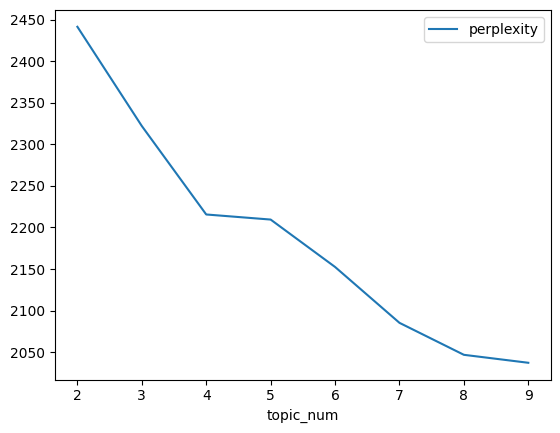

In [36]:
result.plot.line(x='topic_num', y='perplexity')

perplexity越小越好，perplexity在5~8時表現不錯。

<Axes: xlabel='topic_num'>

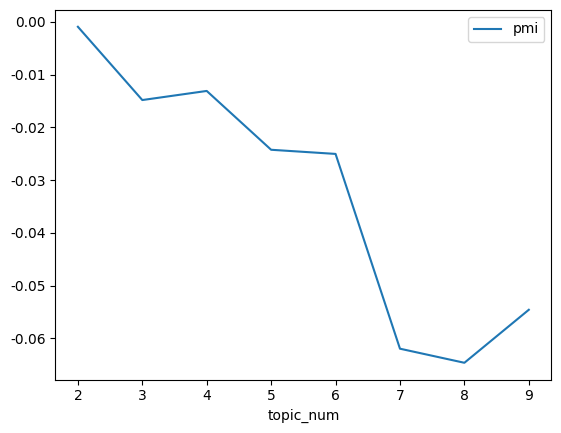

In [37]:
result.plot.line(x='topic_num', y='pmi')

pmi越大越好。就訓練結果來看，在主題數是 7 時表現最好。

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

**以下用主題數 7 、訓練次數 5 次來做 LDAvis**

In [38]:
best_model = LdaModel(
    corpus=corpus,
    num_topics=6,#7改成6 0528
    id2word=dictionary,
    random_state=1500,
    passes=5  # 訓練次數
)

2024-05-28 16:03:13,447 : INFO : using symmetric alpha at 0.16666666666666666
2024-05-28 16:03:13,449 : INFO : using symmetric eta at 0.16666666666666666
2024-05-28 16:03:13,452 : INFO : using serial LDA version on this node
2024-05-28 16:03:13,458 : INFO : running online (multi-pass) LDA training, 6 topics, 5 passes over the supplied corpus of 1184 documents, updating model once every 1184 documents, evaluating perplexity every 1184 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-28 16:03:13,459 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy


2024-05-28 16:03:16,024 : INFO : -9.489 per-word bound, 718.6 perplexity estimate based on a held-out corpus of 1184 documents with 331631 words
2024-05-28 16:03:16,025 : INFO : PROGRESS: pass 0, at document #1184/1184
2024-05-28 16:03:17,409 : INFO : topic #3 (0.167): 0.008*"台灣" + 0.006*"市場" + 0.006*"特斯拉" + 0.006*"電動車" + 0.005*"表示" + 0.005*"指數" + 0.005*"公司" + 0.005*"今年" + 0.005*"全球" + 0.004*"美國"
2024-05-28 16:03:17,411 : INFO : topic #5 (0.167): 0.009*"市場" + 0.007*"電動車" + 0.007*"特斯拉" + 0.005*"台灣" + 0.005*"投資" + 0.005*"今年" + 0.004*"美國" + 0.004*"持續" + 0.004*"充電" + 0.004*"公司"
2024-05-28 16:03:17,411 : INFO : topic #1 (0.167): 0.010*"特斯拉" + 0.009*"電動車" + 0.006*"企業" + 0.006*"市場" + 0.006*"表示" + 0.005*"今年" + 0.005*"台灣" + 0.005*"億元" + 0.005*"美國" + 0.004*"投資"
2024-05-28 16:03:17,412 : INFO : topic #2 (0.167): 0.011*"市場" + 0.010*"電動車" + 0.006*"特斯拉" + 0.006*"台灣" + 0.005*"今年" + 0.005*"美國" + 0.005*"表示" + 0.005*"全球" + 0.004*"成長" + 0.004*"產業"
2024-05-28 16:03:17,417 : INFO : topic #4 (0.167): 0.006*

In [39]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

c:\Users\hands\anaconda3\envs\SMA38\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.021723 -0.090415       1        1  20.919955
2      0.045144 -0.065257       2        1  17.695546
0      0.070509  0.003672       3        1  16.664327
1     -0.115600  0.012820       4        1  15.715459
3     -0.041746  0.062964       5        1  15.181192
5      0.063417  0.076217       6        1  13.823522, topic_info=     Term         Freq        Total Category  logprob  loglift
370   電動車  2840.000000  2840.000000  Default  30.0000  30.0000
985    指數  1085.000000  1085.000000  Default  29.0000  29.0000
1142   車用   573.000000   573.000000  Default  28.0000  28.0000
321    晶片   724.000000   724.000000  Default  27.0000  27.0000
1560   自然   259.000000   259.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
373    需求   123.718251   926.319017   Topic6  -5.9150  -0.0344
447    持續   125.524717  1082.595149   Topic6  -5.9005  -0.1758
464    未來   119.026958   864.859526   Topic6  -5.9536  -0.0044
178    科技   119.127151   984.868459   Topic6  -5.9528  -0.1335
649    產業   116.679283  1185.767218   Topic6  -5.9736  -0.3399

[544 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
5357      2  0.932400   一元化
5357      3  0.025200   一元化
5357      6  0.025200   一元化
5931      1  0.016603  一小部分
5931      2  0.016603  一小部分
...     ...       ...   ...
5840      2  0.029880    點頭
5840      3  0.866527    點頭
5840      4  0.029880    點頭
5840      5  0.059760    點頭
5840      6  0.029880    點頭

[2067 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 2, 4, 6])

可以看到(3,6)、(5,7)很相近，因此再試試看跑5個主題來查看結果

In [40]:
model_5 = LdaModel(
    corpus=corpus,
    num_topics=5,
    id2word=dictionary,
    random_state=6666,  #調參數
    passes=5  # 訓練次數
)

#經過了多次的random_state調參，我們發現random_state=6666時，分類表現最好。

pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2024-05-28 16:05:40,527 : INFO : using symmetric alpha at 0.2
2024-05-28 16:05:40,528 : INFO : using symmetric eta at 0.2
2024-05-28 16:05:40,531 : INFO : using serial LDA version on this node
2024-05-28 16:05:40,538 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 1184 documents, updating model once every 1184 documents, evaluating perplexity every 1184 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-28 16:05:40,539 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-28 16:05:42,887 : INFO : -9.434 per-word bound, 691.7 perplexity estimate based on a held-out corpus of 1184 documents with 331631 words
2024-05-28 16:05:42,888 : INFO : PROGRESS: pass 0, at document #1184/1184
2024-05-28 16:05:44,259 : INFO : topic #0 (0.200): 0.006*"指數" + 0.006*"市場" + 0.005*"成長" + 0.005*"電動車" + 0.005*"今年" + 0.005*"特斯拉" + 0.005*"表示" + 0.005*"科

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.054377  0.005357       1        1  28.013490
2      0.106764  0.007063       2        1  25.529988
0     -0.097711 -0.061324       3        1  24.487004
1      0.011093 -0.039630       4        1  14.321554
3     -0.074523  0.088533       5        1   7.647963, topic_info=    Term         Freq        Total Category  logprob  loglift
370  電動車  2641.000000  2641.000000  Default  30.0000  30.0000
985   指數  1181.000000  1181.000000  Default  29.0000  29.0000
955   上漲   663.000000   663.000000  Default  28.0000  28.0000
281   全球  1395.000000  1395.000000  Default  27.0000  27.0000
160  特斯拉  2373.000000  2373.000000  Default  26.0000  26.0000
..   ...          ...          ...      ...      ...      ...
447   持續    77.993474  1075.165930   Topic5  -5.7844  -0.0529
48    包括    70.312992   595.004940   Topic5  -5.8881   0.4351
314   成長    76.029375  1348.675665   Topic5  -5.8099  -0.3050
985   指數    73.993102  1181.097420   Topic5  -5.8371  -0.1995
32    公司    70.256956  1317.827602   Topic5  -5.8889  -0.3608

[462 rows x 6 columns], token_table=      Topic      Freq Term
term                      
6641      2  0.042442   一加
6641      4  0.042442   一加
6641      5  0.891286   一加
5841      1  0.936916   一瓶
5841      3  0.026769   一瓶
...     ...       ...  ...
1150      5  0.010143   鴻海
1019      2  0.016491   點或
1019      3  0.890516   點或
1019      4  0.032982   點或
1019      5  0.049473   點或

[1497 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 2, 4])

可以看到各主題：1.選舉 2.其他 3.醫藥 4.經濟 5.體育

再試試看跑4個主題來查看有沒有比較好的結果

In [42]:
model_4 = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 6666,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p1 = pyLDAvis.gensim_models.prepare(model_4, corpus, dictionary)
p1

2024-05-28 16:13:18,303 : INFO : using symmetric alpha at 0.25
2024-05-28 16:13:18,305 : INFO : using symmetric eta at 0.25
2024-05-28 16:13:18,307 : INFO : using serial LDA version on this node
2024-05-28 16:13:18,312 : INFO : running online (multi-pass) LDA training, 4 topics, 5 passes over the supplied corpus of 1184 documents, updating model once every 1184 documents, evaluating perplexity every 1184 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-28 16:13:18,313 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-28 16:13:20,499 : INFO : -9.380 per-word bound, 666.3 perplexity estimate based on a held-out corpus of 1184 documents with 331631 words
2024-05-28 16:13:20,500 : INFO : PROGRESS: pass 0, at document #1184/1184
2024-05-28 16:13:21,670 : INFO : topic #0 (0.250): 0.007*"市場" + 0.005*"指數" + 0.005*"成長" + 0.005*"電動車" + 0.005*"特斯拉" + 0.005*"今年" + 0.005*"表示" + 0.005*

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.092635 -0.000174       1        1  36.632450
0     -0.092525 -0.044863       2        1  26.027598
1      0.034183 -0.037831       3        1  24.747175
3     -0.034292  0.082867       4        1  12.592776, topic_info=     Term         Freq        Total Category  logprob  loglift
370   電動車  2692.000000  2692.000000  Default  30.0000  30.0000
985    指數  1151.000000  1151.000000  Default  29.0000  29.0000
955    上漲   653.000000   653.000000  Default  28.0000  28.0000
567    充電   719.000000   719.000000  Default  27.0000  27.0000
160   特斯拉  2347.000000  2347.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
321    晶片   109.556382   716.861014   Topic4  -5.9433   0.1936
48     包括   106.042697   589.500647   Topic4  -5.9759   0.3566
1057   營收   109.098674   868.798793   Topic4  -5.9475  -0.0028
272    企業   110.594137  1431.048153   Topic4  -5.9339  -0.4882
340    目前   107.646488  1002.524740   Topic4  -5.9609  -0.1594

[371 rows x 6 columns], token_table=      Topic      Freq Term
term                      
6641      1  0.039001   一加
6641      3  0.039001   一加
6641      4  0.897015   一加
4357      1  0.090467   一批
4357      2  0.018093   一批
...     ...       ...  ...
5867      4  0.016687   高齡
1019      1  0.017005   點或
1019      2  0.901280   點或
1019      3  0.034011   點或
1019      4  0.051016   點或

[1080 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

可以看到各主題：1.選舉 2.經濟 3.健康 4.體育

## 6. GuidedLDA
安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7~3.8` 可正常執行

In [48]:
import guidedlda

ModuleNotFoundError: No module named 'guidedlda'

In [ ]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一下', '三越', '中小學', '人心', '休閒', '住宅', '住戶', '保護區', '俯瞰', '健康')

In [ ]:
word2id = dictionary.token2id

把政治中的選舉、議會相關分開

In [ ]:
seed_topic_list = [
    ["投資","市場","股價","指數","美元"],
    ["醫師","症狀","糖尿病","治療","患者","健康","感染"],
    ["總統","國民黨","立委","民進黨","侯友宜","參選人"],
    ['亞運','選手','台灣','中華隊','比賽','金牌','決賽','成績','對手'],
    ["市府","議員","台北市","議會"], 
]

In [ ]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [ ]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-03 15:40:10,877 : INFO : n_documents: 8209
2024-05-03 15:40:10,879 : INFO : vocab_size: 22897
2024-05-03 15:40:10,880 : INFO : n_words: 1311245
2024-05-03 15:40:10,880 : INFO : n_topics: 5
2024-05-03 15:40:10,880 : INFO : n_iter: 100
2024-05-03 15:40:17,131 : INFO : <0> log likelihood: -13928265
2024-05-03 15:40:17,912 : INFO : <20> log likelihood: -11222806
2024-05-03 15:40:18,658 : INFO : <40> log likelihood: -11168682
2024-05-03 15:40:19,396 : INFO : <60> log likelihood: -11153730
2024-05-03 15:40:20,131 : INFO : <80> log likelihood: -11146556
2024-05-03 15:40:20,867 : INFO : <99> log likelihood: -11141675


In [ ]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

/opt/anaconda3/envs/sa_python38/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


Topic 0: 台灣 表示 美國 公司 中國 今年 萬元 指出 日本 政府
Topic 1: 醫師 症狀 發現 治療 出現 導致 表示 健康 患者 造成
Topic 2: 總統 國民黨 柯文 侯友宜 民進黨 立委 參選人 民眾 賴清德 候選人
Topic 3: 亞運 選手 台灣 中華隊 比賽 大谷 金牌 拿下 大運 球員
Topic 4: 表示 立委 市長 議員 民進黨 萬安 台北 相關 已經 徐巧


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.075080  0.163708       1        1  35.966596
4     -0.086157  0.183305       2        1  21.402083
0     -0.007602 -0.010616       3        1  14.817262
1     -0.239673 -0.181376       4        1  14.543495
3      0.258351 -0.155021       5        1  13.270564, topic_info=     Term          Freq         Total Category  logprob  loglift
1844   總統  11038.000000  11038.000000  Default  30.0000  30.0000
1561  國民黨   9497.000000   9497.000000  Default  29.0000  29.0000
7476   柯文   7363.000000   7363.000000  Default  28.0000  28.0000
6044  侯友宜   7277.000000   7277.000000  Default  27.0000  27.0000
7395  參選人   4378.000000   4378.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
1706   追蹤    451.464208    636.316947   Topic5  -5.9544   1.6764
3119   朋友    509.394174   1207.878827   Topic5  -5.8336   1.1562
192    今年    531.367610   1538.390356   Topic5  -5.7914   0.9566
142    中國    551.343460   2183.919776   Topic5  -5.7545   0.6431
179    表示    492.414701   6374.477126   Topic5  -5.8675  -0.5411

[349 rows x 6 columns], token_table=       Topic      Freq Term
term                       
442        1  0.646635   一定
442        2  0.107860   一定
442        3  0.064190   一定
442        4  0.125223   一定
442        5  0.056298   一定
...      ...       ...  ...
10177      2  0.016775   飲食
10177      4  0.984116   飲食
5924       1  1.000547  馬英九
16270      2  1.000759  高虹安
13728      2  1.000563   黨工

[643 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 2, 4])

分成的五類與我們的seed_topic區分結果吻合（分成：經濟、健康、選舉、體育、議會）
這說明我們的seed_topic是有效的

再另外嘗試把體育中的籃球、棒球分開

In [ ]:
seed_topic_list = [
    ["職籃", "籃球", "林書豪", "籃板", "助攻","季後賽","西區","雲豹"],
    ['中職', '兄弟', '樂天', "全壘打", "三振", '勝投', '大谷'],
    ["投資","市場","股價","指數","美元"],
    ["總統","國民黨","立委","民進黨","侯友宜","參選人"],
    ["市府","議員","台北市","議會"],
]

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [ ]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-03 15:40:40,794 : INFO : n_documents: 8209
2024-05-03 15:40:40,797 : INFO : vocab_size: 22897
2024-05-03 15:40:40,797 : INFO : n_words: 1311245
2024-05-03 15:40:40,797 : INFO : n_topics: 5
2024-05-03 15:40:40,797 : INFO : n_iter: 100
2024-05-03 15:40:47,058 : INFO : <0> log likelihood: -13964475
2024-05-03 15:40:47,861 : INFO : <20> log likelihood: -11362079
2024-05-03 15:40:48,622 : INFO : <40> log likelihood: -11238169
2024-05-03 15:40:49,371 : INFO : <60> log likelihood: -11198242
2024-05-03 15:40:50,115 : INFO : <80> log likelihood: -11178607
2024-05-03 15:40:50,854 : INFO : <99> log likelihood: -11165779


In [ ]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

/opt/anaconda3/envs/sa_python38/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


Topic 0: 亞運 選手 中華隊 台灣 金牌 比賽 拿下 大運 杭州 最後
Topic 1: 大谷 表示 球員 網友 聯盟 日本 球迷 台灣 球隊 翔平
Topic 2: 台灣 表示 公司 萬元 中國 政府 美國 相關 指出 今年
Topic 3: 總統 國民黨 立委 民進黨 柯文 侯友宜 參選人 市長 民眾 賴清德
Topic 4: 醫師 發現 症狀 表示 出現 治療 導致 造成 健康 指出


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.024610  0.162660       1        1  45.826905
2     -0.109570  0.057724       2        1  19.052728
4     -0.226347 -0.195255       3        1  16.818916
1      0.079008  0.132305       4        1   9.835703
0      0.281519 -0.157434       5        1   8.465749, topic_info=     Term          Freq         Total Category  logprob  loglift
1844   總統  11038.000000  11038.000000  Default  30.0000  30.0000
1561  國民黨   9497.000000   9497.000000  Default  29.0000  29.0000
1483   立委   7811.000000   7811.000000  Default  28.0000  28.0000
6270  民進黨   7586.000000   7586.000000  Default  27.0000  27.0000
7476   柯文   7363.000000   7363.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
142    中國    473.207475   2183.821595   Topic5  -5.4578   0.9398
2925   男子    388.351385    798.011859   Topic5  -5.6554   1.7489
940    這次    395.339534   1316.670198   Topic5  -5.6376   1.2660
303    參加    375.373395    970.956648   Topic5  -5.6894   1.5188
1706   追蹤    364.392018    636.123659   Topic5  -5.7191   1.9120

[344 rows x 6 columns], token_table=       Topic      Freq Term
term                       
1223       1  0.032416   一名
1223       2  0.010373   一名
1223       3  0.698885   一名
1223       4  0.259327   一名
15875      4  1.001069   一平
...      ...       ...  ...
272        3  0.993584   食物
272        4  0.005449   食物
10177      3  0.995211   飲食
10177      5  0.005591   飲食
21117      5  1.001438   體操

[622 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 2, 1])

體育確實分成了兩類，但是結果並不是以籃球、棒球所區分的
在這裡我們可以看到，GuidedLDA的結果並不是完全符合我們的預期

## 7. 主題分佈的應用，搭配其他文章資訊

In [ ]:
# 取得每條新聞的主題分佈
topics_doc = model_5.get_document_topics(corpus)

In [ ]:
topics_doc[100]

[(0, 0.40080926), (4, 0.5922201)]

In [ ]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.81486362, 0.        , 0.        , 0.03733081, 0.14548682],
       [0.85501778, 0.        , 0.0123706 , 0.12702669, 0.        ],
       [0.89635271, 0.        , 0.03952799, 0.        , 0.06074822],
       ...,
       [0.07983947, 0.42180225, 0.        , 0.        , 0.49536517],
       [0.        , 0.99221069, 0.        , 0.        , 0.        ],
       [0.        , 0.81117976, 0.        , 0.        , 0.18022439]])

In [ ]:
data['topic_label'] = m_theta.argmax(axis=1) + 1

In [ ]:
data['topic_label'].value_counts()

4    3461
5    1295
2    1261
1    1193
3     999
Name: topic_label, dtype: int64

In [ ]:
data.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,台南安平區除有歷史悠久的古蹟外開發近年的五期重劃區兼具生活機能及慢活悠閒步調是許多在地人心之...,https://news.ebc.net.tw/news/article/365123,財經,2023-05-05 14:00:00,"[台南, 安平, 區除, 歷史悠久, 古蹟, 開發, 近年, 五期, 重劃, 兼具, 生活,...",1
1,美國股神巴菲特今天盛讚台積電是了不起的公司但承認旗下波克夏海瑟威公司把資金配置在日本比配置在...,https://news.ebc.net.tw/news/article/365550,財經,2023-05-08 11:30:00,"[美國, 股神, 巴菲特, 今天, 盛讚, 台積, 電是, 了不起, 公司, 承認, 旗下,...",1
2,為了幫助弱勢族群期交所攜手金融機構辦理食物銀行捐贈食物和生活用品今年總捐贈金額更達萬元是歷年...,https://news.ebc.net.tw/news/article/365827,財經,2023-05-10 17:31:00,"[幫助, 弱勢, 族群, 期交所, 攜手, 金融機構, 辦理, 食物, 銀行, 捐贈, 食物...",1
3,今天舉辦年度開發者大會發表款硬體新產品包括中階手機折疊手機及平板電腦並宣布旗下生成式人工智慧...,https://news.ebc.net.tw/news/article/365885,財經,2023-05-11 10:01:00,"[今天, 舉辦, 年度, 開發者, 大會, 發表, 硬體, 產品, 包括, 中階, 手機, ...",1
4,日前一輛新車因停車格塌陷而爆出新竹天坑事件以及快速道路死亡車禍引起汽車險業者高度關注雖然兩起...,https://news.ebc.net.tw/news/article/366027,財經,2023-05-12 09:21:00,"[日前, 一輛, 新車, 停車, 塌陷, 爆出, 新竹, 天坑, 事件, 快速道路, 死亡,...",1


In [ ]:
data['artDate'] = pd.to_datetime(data['artDate'])


依照年和月來查看各主題隨時間的分布狀況

In [ ]:
data.groupby([data['artDate'].dt.year,data['artDate'].dt.month])['topic_label'].value_counts(normalize=True)

artDate  artDate  topic_label
2023     5        4              0.477193
                  3              0.175439
                  2              0.152632
                  5              0.114035
                  1              0.080702
         6        4              0.333333
                  5              0.304527
                  3              0.150206
                  2              0.115226
                  1              0.096708
         7        4              0.379004
                  2              0.281139
                  5              0.129893
                  1              0.104982
                  3              0.104982
         8        2              0.350254
                  4              0.304569
                  5              0.149746
                  3              0.116751
                  1              0.078680
         9        2              0.370508
                  4              0.262701
                  5              0.187113
    

In [ ]:
date_topic = data.groupby([data['artDate'].dt.year,data['artDate'].dt.month])['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label             1         2         3         4         5
artDate artDate                                                  
2023    5        0.080702  0.152632  0.175439  0.477193  0.114035
        6        0.096708  0.115226  0.150206  0.333333  0.304527
        7        0.104982  0.281139  0.104982  0.379004  0.129893
        8        0.078680  0.350254  0.116751  0.304569  0.149746
        9        0.112763  0.370508  0.066914  0.262701  0.187113

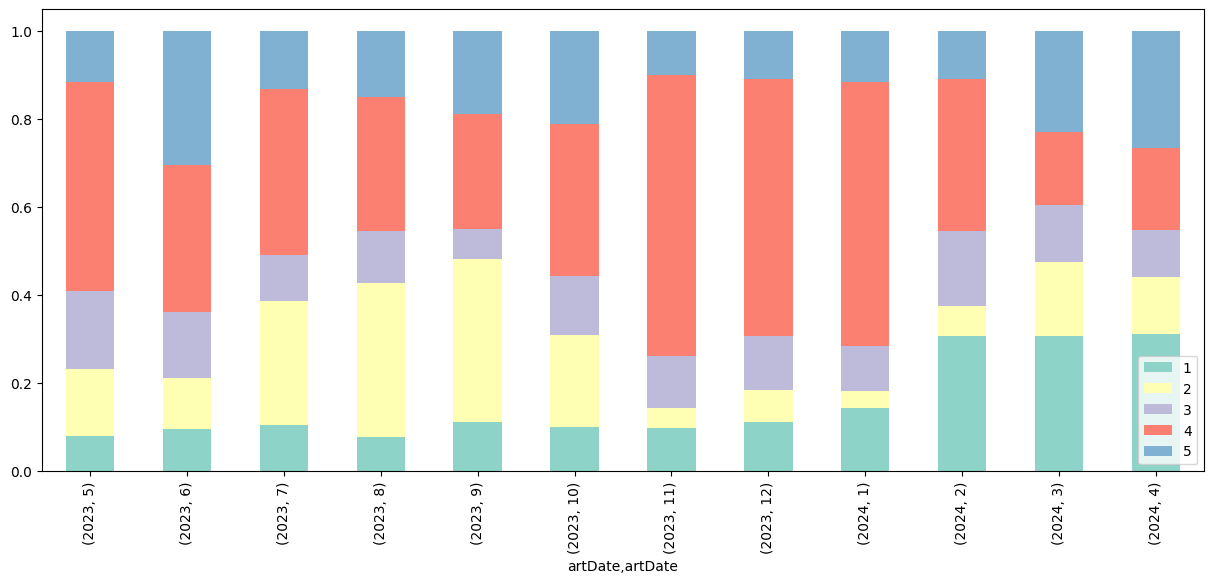

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

圖中的各主題分別是 : 
1. 經濟
2. 其他
3. 體育
4. 選舉
5. 醫藥

可以發現，在總統大選前（2024年1月），選舉相關新聞數量逐漸增加，當選舉完後（2024年2月），數量逐漸減少。

結論：  
- 我們嘗試了使用4、5、7個類別來查看分群狀況。其中，我們認為模型分群效果最佳的是落在4或5個主題之間。  
- 當嘗試7或4個主題時，結果發現模型會將經濟相關的內容與其他主題混合在一起，導致很難區分出來。  
- 因此最終我們選擇了使用 **5 個主題**的模型作為 best model。
- 在嘗試變更超參數時，我們發現到num_topics會顯著影響到模型的分群效果，因此我們認為這是一個重要的超參數。
- 此外，在調整過程中random_state也會影響到模型的分群效果，因此使用該方法分析主題時，會受到隨機性的影響。